In [1]:
import astropy
from astropy import units
from astropy.coordinates import SkyCoord
import numpy
import matplotlib.pyplot as plt

First get coordinates from Ae aur and Mu Col. Using data from Gaia Dr2 

In [2]:
#lonlat = ["5h16m18.15s +34d18m44.0s", " 5h45m59.89s -32d18m44.0s"]
star_names = ['Ae Aur', 'Mu Col']
ra = [79.07559745673318,86.49957923452477 ]*units.deg
dec = [34.312505337886705,-32.30652949616978 ]*units.deg
pmra = [ -4.4396,2.9881]#units.mas/units.yr 
pmdec = [43.36777,-22.02968]#*units.mas/units.yr
parallax = [2.24,2.52]
radial_velocity = [57.5,109.0]
coords = SkyCoord(#lonlat,unit=(units.hourangle,units.deg)                 
                ra = ra, dec=dec
                ,pm_ra_cosdec = pmra* units.mas/units.yr, pm_dec = pmdec* units.mas/units.yr                   
                ,distance = numpy.clip(1000.0/numpy.array(parallax),0,1E5 )*units.parsec 
                ,radial_velocity=radial_velocity*units.km/units.s
                ,obstime="J1991.25")
coords = coords.galactic
print(coords)

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, pc)
    [(172.08115261,  -2.25914075, 446.42857143),
     (237.28627192, -27.10208942, 396.82539683)]
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(-37.91870614, 21.50918984,  57.5),
     ( 21.97672422, -3.35546347, 109. )]>


Following function corrects for solar peculiar motion. It just substract the projected solar proper motion in the given star.
The equation for correcting the radial velocity is also there but not used.

coords

In [3]:
def correct_gpm(l,b,pmlstar,pmb,distance):
    u_s,v_s,w_s=[11.1,12.24,7.25] * units.km/units.s #Schronich+2010
    cos = numpy.cos
    sin = numpy.sin
    
    vrad_solm = ( -u_s*cos(l)*cos(b) - v_s*sin(l)*cos(b) - w_s*cos(b) )         
    pml_solm  = ( u_s*sin(l)-v_s*cos(l) )/cos(b)*units.rad/distance                 
    pmb_solm  = ( u_s*cos(l)*sin(b) + v_s*sin(l)*sin(b) - w_s*cos(b) )*units.rad/distance

    
    pml_c = pmlstar/cos(b) - pml_solm                              
    pmb_c = pmb - pmb_solm
            
    return pml_c,pmb_c
    #return pmlstar/numpy.cos(b), pmb

Below I show how I use above functions to calculate trajectories.
First defining a function to compute the full trajectory on the celestial sphere, and also associate a time for 
each point assuming the proper motion do not change with time. 

This trajectory would give a complete circle around the celestial sphere. But of course we only use a fraction of that trajectory.

Then, the resulting traceback times are not correct, since proper motions change with time because of the projection on the celestial sphere. These times are used just as reference, only a 3D traceback gives the right traceback time.

In [4]:
def great_circles_trajectory(l,b,pmlc,pmbc,N=100,with_time=False,
                             limits=None,start_from_star=True):
    """ Computes the complete trajectory over the surface of the celestial sphere in straigth line 
    neeeds coordinates and pm : l,b, and propermotions pml,pmb                  
    N : the number of points to sample                                          
    proper motions should be corrected by solar motion    
                                                                                
    """                                                                         
                                                          
    array_like = hasattr(l.value,"__len__")                                 
    if limits is not None:                                                      
        limits = limits.to_value(units.degree)                                      
    else:                                                                       
        limits = [0,360]                                                        
                                                                                
    if array_like:                                                              
        ### reshaping for array arithmetic                                      
        ### variables capital letters have shapes (len(l),N)          
        ### Then each row contains the trajectory of the corresponding particle
        Lsample = numpy.array([ numpy.linspace(limits[0],limits[1],N) ]*len(l)) * units.deg
                                                                                                                                      
        L  = numpy.array([l.value]*N).transpose() * l.unit                      
        B  = numpy.array([b.value]*N).transpose() * b.unit                      
        PML  = numpy.array([pmlc.value]*N).transpose() * pmlc.unit                 
        PMB  = numpy.array([pmbc.value]*N).transpose() * pmbc.unit              
        toflip = pmlc > 0  # inverse trajectory of stars with positive propermotion (we are looking back)
        if start_from_star :                                                    
            Lsample = Lsample + L # The starting point of the trajectory should be the position of the star
        Lsample[toflip] = Lsample[toflip,::-1] #do the inversion on selected particles
                                                                                                        
        axis = 1
    else:                                                                       
        Lsample = (numpy.linspace(limits[0],limits[1],N) * units.deg)               
        if start_from_star:                                                     
            Lsample+=l                                                          
        if (pmlc > 0 ):                                                         
            Lsample = Lsample[::-1]                                             
        L,B = l,b                                                               
        PML,PMB  = pmlc,pmbc
        
        axis = 0                                                                
                                                                                
    Lsample = numpy.remainder( Lsample.to_value(units.deg),360) * units.deg #convert values above 360 to periodic
    
    ## Lsample will follow the (past) trajectory starting from the location of each star
    ## flip is necessary for the stars with positive proper motions so the past trajectory goes in the opossite direction
    ## This is important for later when associating a time to each point in the trajectory
    NUM1 = PML*numpy.cos(B)*numpy.sin(B)*numpy.cos(Lsample-L)                         
    NUM2 = PMB*numpy.sin(Lsample-L)                                                   
    DEN  = PML*(numpy.cos(B) )**2                                               
                                                
                                                                                
    TGBSAMPLE = (NUM1+NUM2)/DEN                                                 
    Bsample = numpy.arctan(TGBSAMPLE).to(units.deg)                                 
    if not with_time:                                                           
        return Lsample, Bsample                                             
    else:                                                                       
        #assosiate a time for each point in trajectory                                                             
        pm = numpy.sqrt(PML**2 + (PMB)**2)                                  
        #pm = numpy.sqrt( (PML*cos(Bsample) )**2 + (PMB)**2)                
        L2 = numpy.roll(Lsample,1,axis=axis)                                
        B2 = numpy.roll(Bsample,1,axis=axis)                                
        THETA = great_circle_distance(Lsample,Bsample,L2,B2)                
        #THETA = great_circle_distance(Lsample,Bsample,L,B)                 
        THETA = numpy.nancumsum(THETA,axis=axis)                            
        Tsample = (THETA/pm).to(units.year)                                     
        return Lsample,Bsample,Tsample #Tsample have units
            

Following function is just the great circle distance between 2 points.


In [5]:
def great_circle_distance(l1,b1,l0,b0):                                         
    " returns great circle distance between two points"                         
    term1   = numpy.sin(b0)*numpy.sin(b1)                                                   
    term2   = numpy.cos(b0)*numpy.cos(b1)*numpy.cos(l1-l0)                                        
    return numpy.arccos( term1 + term2 )


Here is the example on how to use above functions for the trajectory of AeAur and MuCol.

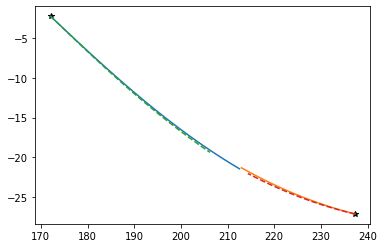

In [6]:
l,b = coords.l,coords.b 
#Corrected trajectory
pmlc,pmbc = correct_gpm(coords.l,coords.b,coords.pm_l_cosb,coords.pm_b,distance=coords.distance)
lsample,bsample,tsample = great_circles_trajectory(l,b,pmlc,pmbc,N=10000,with_time=True,
                             limits=None,start_from_star=True)
#uncorrected trajectory
lunc,bunc,tunc = great_circles_trajectory(l,b,coords.pm_l_cosb/numpy.cos(coords.b),
                                          coords.pm_b,N=10000,with_time=True,
                                          limits=None,start_from_star=True)

tback = 3.1*units.Myr  

plt.plot(coords.l,coords.b,"*k")
for l,b,t in zip(lsample,bsample,tsample):
    mask = t < tback 
    plt.plot(l[mask],b[mask])


    
for l,b,t in zip(lunc,bunc,tunc):
    mask = t < tback 
    plt.plot(l[mask],b[mask],ls="dashed")


From [Runaway and walkaway stars from the ONC with Gaia DR2](https://arxiv.org/pdf/2004.13730.pdf)

In [7]:
ONC = SkyCoord(#lonlat,unit=(units.hourangle,units.deg)                 
                ra = '5:35:16', dec='-05:23:40', unit=(units.hourangle,units.deg) 
                ,pm_ra_cosdec =1.43*units.mas/units.yr, pm_dec = 0.52 * units.mas/units.yr                   
                ,distance = numpy.clip(1000.0/numpy.array(2.5),0,1E5 )*units.parsec 
                ,radial_velocity=21.8*units.km/units.s                       
                ,obstime="J2000")
ONC = ONC.galactic

In [8]:
ONC

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, pc)
    (209.01431152, -19.3879187, 400.)
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    (0.1830436, 1.51056117, 21.8)>

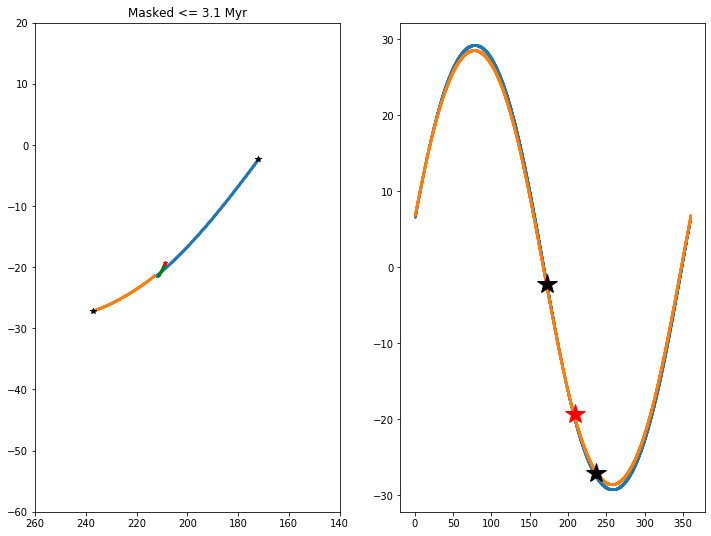

In [9]:
l,b = coords.l,coords.b 
#Corrected trajectory
pmlc,pmbc = correct_gpm(coords.l,coords.b,coords.pm_l_cosb,coords.pm_b,distance=coords.distance)
lsample,bsample,tsample = great_circles_trajectory(coords.l,coords.b,pmlc,pmbc,N=10000,with_time=True,
                             limits=None,start_from_star=True)
# Correct the ONC
pmlc_onc, pmbc_onc = correct_gpm(ONC.l, ONC.b, ONC.pm_l_cosb, ONC.pm_b, distance = ONC.distance)
lsample_onc,bsample_onc,tsample_onc = great_circles_trajectory(ONC.l,ONC.b,pmlc_onc,pmbc_onc,N=10000,with_time=True,
                             limits=None,start_from_star=True)


tback = 3.1*units.Myr


fig = plt.figure(figsize=(12,9))
ax = fig.subplots(1,2)

ax[0].plot(coords.l,coords.b,"*k")
for l,b,t in zip(lsample,bsample,tsample):
    mask = t < tback
    #mask = numpy.arange(len(l))
    ax[0].scatter(l[mask],b[mask], s=1)

ax[0].plot(ONC.l,ONC.b,"*k", color='red', ms=5)   
mask = tsample_onc < tback
#mask=numpy.arange(len(lsample_onc))
ax[0].scatter(lsample_onc[mask],bsample_onc[mask], s=1,color='green')

#plt.gca().invert_xaxis()
ax[0].set_xlim(260,140)
ax[0].set_ylim(-60,20)
ax[0].set_title(f'Masked <= {tback}')

ax[1].plot(coords.l, coords.b, '*k',  ms=20)
for l,b,t in zip(lsample,bsample,tsample):
    ax[1].scatter(l,b, s=1)
ax[1].plot(ONC.l,ONC.b,"*k", color='red', ms=20)

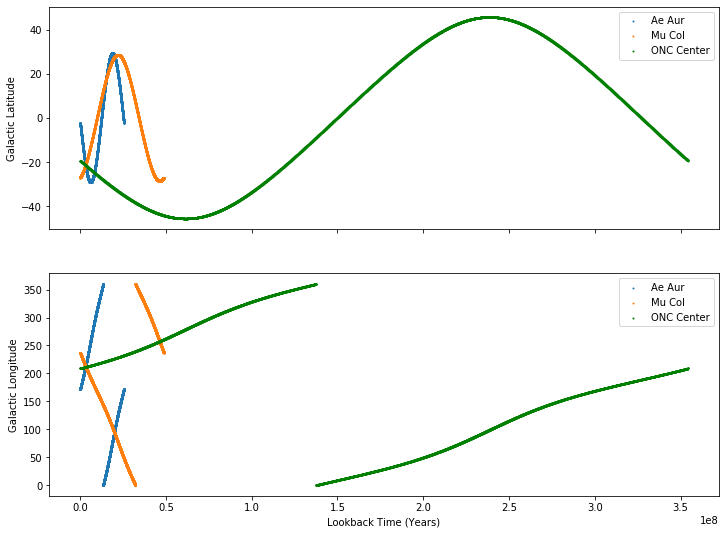

In [10]:
fig = plt.figure(figsize=(12,9))
ax = fig.subplots(2,1, sharex=True)


for l,b,t,n in zip(lsample,bsample,tsample, star_names):
    ax[0].scatter(t,b, s=1, label=n)
ax[0].scatter(tsample_onc,bsample_onc, s=1,color='green', label='ONC Center')
ax[0].set_ylabel('Galactic Latitude')
ax[0].legend()

for l,b,t,n in zip(lsample,bsample,tsample, star_names):
    ax[1].scatter(t,l, s=1, label=n)
ax[1].scatter(tsample_onc,lsample_onc, s=1,color='green', label='ONC Center')
ax[1].set_ylabel('Galactic Longitude')
ax[1].set_xlabel('Lookback Time (Years)')
ax[1].legend()

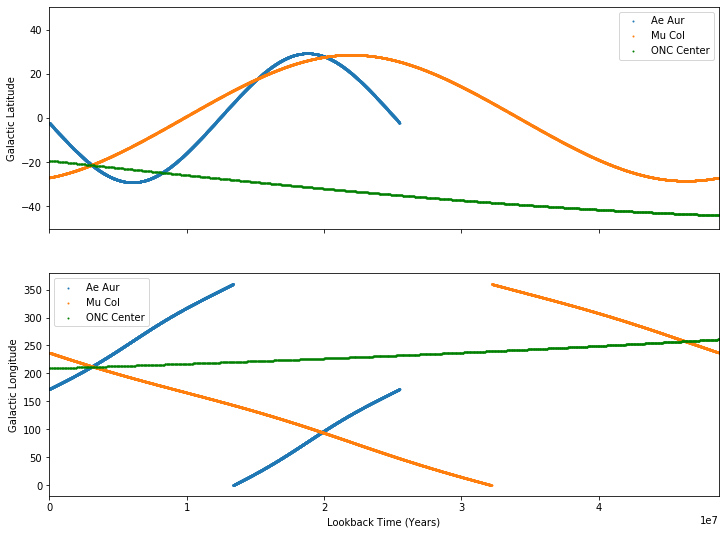

In [11]:
max_lbt = tsample.max().value

fig = plt.figure(figsize=(12,9))
ax = fig.subplots(2,1, sharex=True)


for l,b,t,n in zip(lsample,bsample,tsample, star_names):
    ax[0].scatter(t,b, s=1, label=n)
ax[0].scatter(tsample_onc,bsample_onc, s=1,color='green', label='ONC Center')
ax[0].set_ylabel('Galactic Latitude')
ax[0].set_xlim(0,max_lbt)
ax[0].legend()

for l,b,t,n in zip(lsample,bsample,tsample, star_names):
    ax[1].scatter(t,l, s=1, label=n)
ax[1].scatter(tsample_onc,lsample_onc, s=1,color='green', label='ONC Center')
ax[1].set_ylabel('Galactic Longitude')
ax[1].set_xlim(0,max_lbt)
ax[1].set_xlabel('Lookback Time (Years)')
ax[1].legend()

### Find Time when These Two Stars were closest to Center

In [12]:
# interpolation model for center
from scipy import interpolate as intrp
import numpy as np

# just need to define the interpolation over timespan of the candidate stars
# don't need this
#max_lbt = tsample.max()
#mask = tsample_onc <= max_lbt

intrp_onc_l = intrp.interp1d(tsample_onc,lsample_onc, kind='cubic')
intrp_onc_b = intrp.interp1d(tsample_onc,bsample_onc, kind='cubic')

#get the onc's position at each stars' timesteps
onc_l = np.array([intrp_onc_l(t) for t in tsample])*units.degree
onc_b = np.array([intrp_onc_b(t) for t in tsample])*units.degree

In [13]:
#find each star's separation from center at each star's timesteps
seps = np.array([great_circle_distance(sl, sb, cl, cb)\
                 for sl, sb, cl, cb in zip(lsample, bsample, onc_l, onc_b)])
min_seps_i = seps.argmin(axis=1)
min_seps   = np.array([s[i]       for s,i in zip(seps, min_seps_i)])*units.radian
min_seps_t = np.array([t[i].value for t,i in zip(tsample, min_seps_i)])*units.year
min_seps_l = np.array([l[i].value for t,i in zip(lsample, min_seps_i)])*units.degree
min_seps_b = np.array([b[i].value for t,i in zip(bsample, min_seps_i)])*units.degree


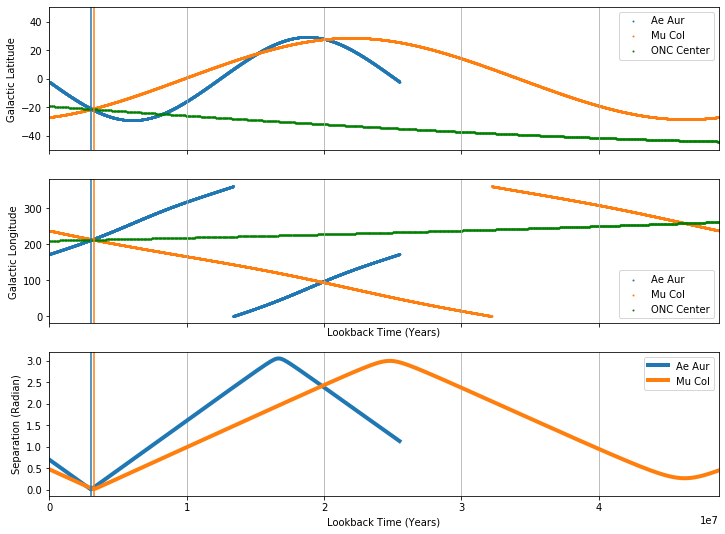

In [14]:
max_lbt = tsample.max().value

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig = plt.figure(figsize=(12,9))
ax = fig.subplots(3,1, sharex=True)


for l,b,t,n,c in zip(lsample,bsample,tsample, star_names, colors):
    ax[0].scatter(t,b, s=1, label=n, color=c)
for t,c in zip(min_seps_t, colors):
    ax[0].axvline(t.value,  color=c)
ax[0].scatter(tsample_onc,bsample_onc, s=1,color='green', label='ONC Center')
ax[0].set_ylabel('Galactic Latitude')

for l,b,t,n,c in zip(lsample,bsample,tsample, star_names, colors):
    ax[1].scatter(t,l, s=1, label=n, color=c)
for t,c in zip(min_seps_t,colors):
    ax[1].axvline(t.value, color=c)
ax[1].scatter(tsample_onc,lsample_onc, s=1,color='green', label='ONC Center')
ax[1].set_ylabel('Galactic Longitude')
ax[1].set_xlabel('Lookback Time (Years)')


#separation
for s, t,n, c in zip(seps, tsample, star_names, colors):
    ax[2].plot(t,s, lw=4, label=n, color=c)
for t,c in zip(min_seps_t,colors):
    ax[2].axvline(t.value, color=c)
ax[2].set_ylabel('Separation (Radian)')
ax[2].set_xlabel('Lookback Time (Years)')

for a in ax:
    a.set_xlim(0,max_lbt)
    a.grid(axis='x')
    a.legend()

In [15]:
seps.shape

(2, 10000)

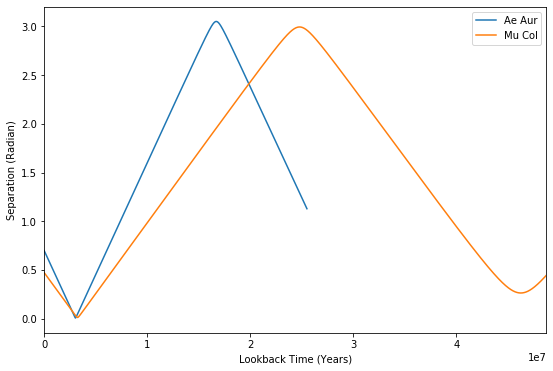

In [16]:
max_lbt = tsample.max().value

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot()

for s, t,n in zip(seps, tsample, star_names):
    ax.plot(t,s,  label=n)

ax.set_ylabel('Separation (Radian)')
ax.set_xlim(0,max_lbt)
ax.set_xlabel('Lookback Time (Years)')
ax.legend()

## Test Distance Derivatives

#### Great circle distance a signed quantity?

In [20]:
great_circle_distance(ONC.l, ONC.b, coords[0].l, coords[0].b)

<Quantity 0.69740956 rad>

In [21]:
great_circle_distance(coords[0].l, coords[0].b, ONC.l, ONC.b)

<Quantity 0.69740956 rad>

In [24]:
ONC.separation(coords[0]).to(units.radian)

<Angle 0.69740956 rad>

In [26]:
coords[0].separation(ONC).radian

0.6974095591296872

great circle distance doesn't appear to be a signed quantity

In [42]:
def dist_derivative(c1, c2, correct_solar_motion=True):
    # need to make this work for arrays of coords
    
    if correct_solar_motion:
        pm1 = correct_gpm(c1.l,c1.b,c1.pm_l_cosb,c1.pm_b,distance=c1.distance)
        pm2 = correct_gpm(c2.l,c2.b,c2.pm_l_cosb,c2.pm_b,distance=c2.distance)
        
        pm1 = np.array([p.value for p in pm1])
        pm2 = np.array([p.value for p in pm2])
    else:
        pm1 = np.array([c1.pm_l_cosb.value, c1.pm_b.value])
        pm2 = np.array([c2.pm_l_cosb.value, c2.pm_b.value])
        
    dist = np.sqrt((c1.l - c2.l)**2 + (c1.b - c2.b)**2).value
    
    numerator = (c1.l.value-c2.l.value)*(pm1[0]- pm2[0]) + (c1.b.value-c2.b.value)*(pm1[1]-pm2[1])
    
    deriv = numerator/dist
    
    return deriv

In [45]:
dist_derivative(coords[0], ONC, correct_solar_motion=False)

42.979398464648376

In [46]:
dist_derivative(coords[1], ONC, correct_solar_motion=False)

22.30596575267874

In [29]:
coords[0].l- ONC.l

<Angle -36.93315891 deg>

In [73]:
min_seps.to(units.degree)

<Quantity [0.36769283, 0.68189369] deg>

In [71]:
min_seps_l

<Quantity [197.75431872, 211.90373366] deg>

In [55]:
tsample[0, 1098], tsample[1, 705]

(<Quantity 3033892.32710805 yr>, <Quantity 3240150.63989374 yr>)

In [56]:
tsample[:, seps.argmin(axis=1)]

<Quantity [[3033892.32710805, 2000317.60450735],
           [5203958.00225092, 3240150.63989374]] yr>

In [41]:
tsample_onc[mask].max()

<Quantity 48701310.42765462 yr>

In [25]:
tsample.max(axis=1), tsample_onc.max()

(<Quantity [25491479.05279829, 48726106.72400119] yr>,
 <Quantity 3.54210086e+08 yr>)

In [ ]:
tmin = tsample_pleiades.min().value; tmax=tsample_pleiades.max().value
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(projection='mollweide')
pcm = ax.scatter(Angle(lsample_pleiades).wrap_at(180*units.degree).to_value(units.radian), bsample_pleiades.to_value(units.radian),
                 s=2, c=tsample_pleiades.value, vmin=tmin, vmax=tmax)
ax.plot(coords_pleiades.l.wrap_at(180*u.degree).radian,coords_pleiades.b.radian,"*r")
ax.grid()
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactice Latitude')
ax.set_title('Pleiades Member Great Circle Trajectories')
plt.colorbar(pcm, label='Traceback Time (Years)')

## Great Circle Distances

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Compare Computed Deltas to `pml` and `pmb`

Get the change in longitude and latitude between adjacent points on the trajectory and convert to millisarcseconds per year. How does this compare to `pml` and `pmb`?

In [18]:
#get the deltas between adjacent points
# v[t] =  x[t]-x[t-1]
delta_l = (lsample_onc - np.roll(lsample_onc,1))[1:].to(units.mas)
delta_b = (bsample_onc - np.roll(bsample_onc,1))[1:].to(units.mas)
delta_t = (tsample_onc - np.roll(tsample_onc,1))[1:]

In [19]:
delta_l_pred = ((360*units.degree)/(len(lsample_onc)-1)).to(units.mas) 
print(f'Preicted intersample delta l: {delta_l_pred}')
delta_l

Preicted intersample delta l: 129612.9612961296 mas


<Quantity [129612.96129612, 129612.96129612, 129612.96129612, ...,
           129612.96129602, 129612.96129643, 129612.96129602] mas>

In [25]:
np.allclose(delta_l, delta_l_pred)

False

In [31]:
ind_i = np.arange(len(delta_l))
large_val_i = ind_i[np.abs(delta_l/delta_l_pred -1)  > 1e-5]

large_val_i

array([4193])

In [34]:
lsample_onc[4190:4195]

<Quantity [3.59869397e+02, 3.59905401e+02, 3.59941404e+02, 3.59977408e+02,
           1.34114330e-02] deg>

Some discontinuity when the thing wraps around

In [83]:
#predict tsample[tval] at arbirtry time tval
tval = 1000
sep = great_circle_distance(lsample_onc[tval],bsample_onc[tval],lsample_onc[tval-1],bsample_onc[tval-1])
v = np.sqrt(pmlc_onc**2 + pmbc_onc**2).to(units.radian/units.year)

#tsample is cumulative
tsample_onc[tval] - tsample_onc[tval-1], sep/v


(<Quantity 29442.04180855 yr>, <Quantity 29442.04180855 yr>)

above confirms that the time between two adjacent point on trajectory is the angular separation divided by the euclidean magnitude of the proper motion components.  The $l$ component, does **not** include the $cos b$ factor.

## Predict `lsample` as function of intial position, motion and time?

In [37]:
#lsample[0] should be initial position of star, which should match ONC.l
lsample_onc[0], ONC.l

(<Quantity 209.01431152 deg>, <Longitude 209.01431152 deg>)

In [84]:
delta_l[tval]/delta_t[tval]

<Quantity 4.4038678 mas / yr>

In [38]:
#tsample[0] should be 0
tsample_onc[0]

<Quantity 0. yr>

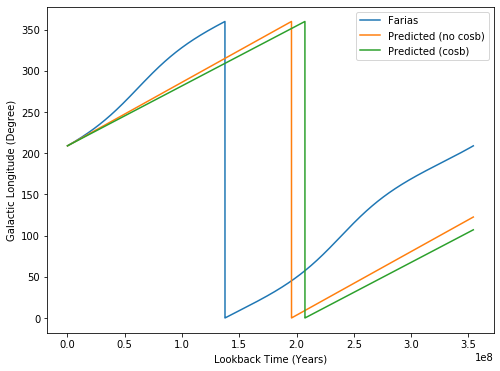

In [55]:
#Predict lsample
lsample_onc_pred = np.remainder(ONC.l - tsample_onc*pmlc_onc, 360*units.degree)
cosb = np.cos(ONC.b)
sinb = np.sin(ONC.b)
lsample_onc_pred_cosb = np.remainder(ONC.l - tsample_onc*pmlc_onc*cosb, 360*units.degree)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.plot(tsample_onc, lsample_onc, label='Farias')
ax.plot(tsample_onc, lsample_onc_pred, label='Predicted (no cosb)')
ax.plot(tsample_onc, lsample_onc_pred_cosb, label='Predicted (cosb)')
ax.set_ylabel('Galactic Longitude (Degree)')
ax.set_xlabel('Lookback Time (Years)')
ax.legend()

In [95]:
pmlc_onc/(np.sin(ONC.l)*np.cos(ONC.b))

<Quantity 6.07679032 mas / yr>

In [94]:
np.array([np.sin(ONC.l), np.cos(ONC.l), np.sin(ONC.b), np.cos(ONC.b)])

array([-0.48502807, -0.87449858, -0.33196224,  0.94329268])

Text(0.5, 0, 'Sample Number')

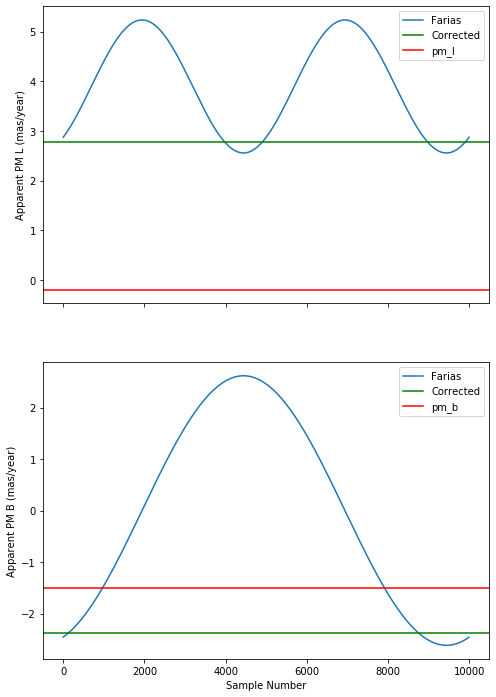

In [86]:
mask = (delta_l/delta_t) >= 0 # ditch an outlier

fig = plt.figure(figsize=(8,12))
ax = fig.subplots(2,1, sharex=True)
ax[0].plot((delta_l/delta_t)[mask], label='Farias')
ax[0].set_ylabel('Apparent PM L (mas/year)')
ax[0].axhline(-pmlc_onc.value, label='Corrected', color='green')
ax[0].axhline(-ONC.pm_l_cosb.value/np.cos(ONC.b), label='pm_l', color='red')
ax[0].legend()

ax[1].plot((delta_b/delta_t)[mask], label='Farias')
ax[1].axhline(-pmbc_onc.value, label='Corrected', color='green')
ax[1].axhline(-ONC.pm_b.value, label='pm_b', color='red')
ax[1].legend()
ax[1].set_ylabel('Apparent PM B (mas/year)')
ax[1].set_xlabel('Sample Number')

### Model Great Circle distances?

In [14]:
ONC.b, ONC.pm_l_cosb, ONC.pm_l_cosb.value/np.cos(ONC.b),  np.cos(ONC.b)

(<Latitude -19.3879187 deg>,
 <Quantity 0.1830436 mas / yr>,
 <Quantity 0.19404752>,
 <Quantity 0.94329268>)

In [15]:
nyears = delta_t[0]
l0 = ONC.l; b0 = ONC.b
l1 = ONC.l + pmlc_onc*nyears;  b1 = ONC.b + pmbc_onc*nyears

In [16]:
l1.to_value(units.degree) - l0.to_value(units.degree)

-0.03483272136836035

In [17]:
(pmlc_onc*nyears).to_value(units.degree)

-0.03483272136835074

In [18]:
b1.to_value(units.degree) - b0.to_value(units.degree)

0.029798997126572857

In [19]:
(pmbc_onc*nyears).to_value(units.degree)

0.029798997126572562

In [20]:
great_circle_distance(l1,b1, l0,b0).to(units.mas)

<Quantity 159695.19708056 mas>

In [21]:
nyears*np.sqrt(pmlc_onc**2+pmbc_onc**2)

<Quantity 165023.72935873 mas>

In [22]:
nyears*np.sqrt(pmlc_onc**2+pmbc_onc**2)/great_circle_distance(l1,b1, l0,b0).to(units.mas)

<Quantity 1.03336689>

3.33 % off from the great circle distance

## Great Circle Distance versus Euclidean

In [29]:
nyears = 1e6*units.year
l0 = ONC.l; b0 = ONC.b
l1 = ONC.l + pmlc_onc*nyears;  b1 = ONC.b + pmbc_onc*nyears
print(f'Great Circle Distance: {great_circle_distance(l1, b1, l0, b0)}')
euclid_distance = (nyears*np.sqrt((pmlc_onc*np.cos(ONC.b))**2+(pmbc_onc)**2)).to(units.radian)
print(f'Euclid Distance: {euclid_distance}')
print(f'Percent Difference: {100.0*(great_circle_distance(l1, b1, l0, b0)/euclid_distance -1):.2f}%')

Great Circle Distance: 0.01718383593817096 rad
Euclid Distance: 0.01716495253363862 rad
Percent Difference: 0.11%


In [166]:
np.array([np.sin(ONC.l), np.cos(ONC.l), np.sin(ONC.b), np.cos(ONC.b)])

array([-0.48502807, -0.87449858, -0.33196224,  0.94329268])

In [27]:
tsample_onc

<Quantity [0.00000000e+00, 4.51026770e+04, 9.01882731e+04, ...,
           3.54119829e+08, 3.54164966e+08, 3.54210086e+08] yr>

In [48]:
l_t = np.remainder(ONC.l - tsample_onc*(pmlc_onc*np.cos(ONC.b)), 360*units.degree)
b_t = ONC.b - tsample_onc*(pmbc_onc)

In [49]:
l_t

<Angle [209.01431152, 209.04716897, 209.08001398, ..., 106.99179103,
        107.02467334, 107.05754323] deg>

In [50]:
lsample_onc

<Quantity [209.01431152, 209.05031512, 209.08631872, ..., 208.94230432,
           208.97830792, 209.01431152] deg>

Text(0.5, 0, 'Look Back Time (years)')

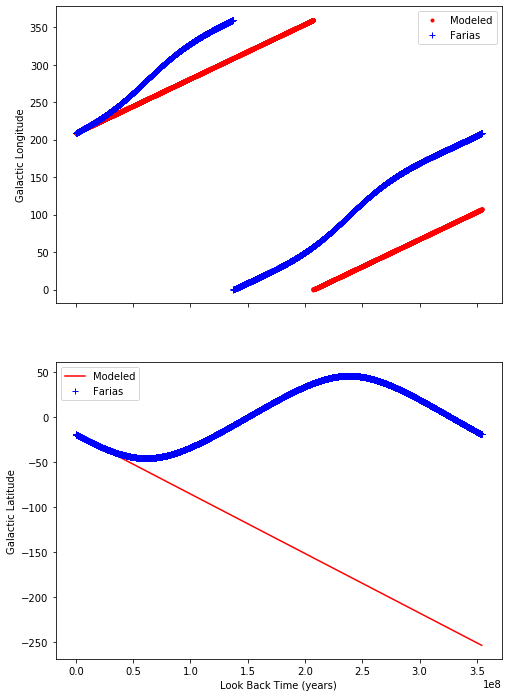

In [52]:
fig = plt.figure(figsize=(8,12))
ax = fig.subplots(2,1, sharex=True)
ax[0].plot(tsample_onc, l_t, '.', label='Modeled', color='red')
ax[0].plot(tsample_onc, lsample_onc, '+', label='Farias', color='blue')
ax[0].set_ylabel('Galactic Longitude')
ax[0].legend()

ax[1].plot(tsample_onc, b_t, label='Modeled', color='red')
ax[1].plot(tsample_onc, bsample_onc, '+', label='Farias', color='blue')
ax[1].legend()
ax[1].set_ylabel('Galactic Latitude')
ax[1].set_xlabel('Look Back Time (years)')

In [72]:
def get_trajectory(l, b, pmlc, pmbc, t):
    
    Lsample = np.remainder(l+t*pmlc*numpy.cos(b), 360*units.degree)
    
    NUM1 = pmlc*numpy.cos(b)*numpy.sin(b)*numpy.cos(Lsample-l)                         
    NUM2 = pmbc*numpy.sin(Lsample-l)                                                   
    DEN  = pmlc*(numpy.cos(b) )**2                                               
                                                
                                                                                
    TGBSAMPLE = (NUM1+NUM2)/DEN                                                 
    Bsample = numpy.arctan(TGBSAMPLE).to(units.deg)
    
    return Lsample, Bsample

In [73]:
l_t, b_t = get_trajectory(ONC.l, ONC.b, pmlc_onc, pmbc_onc, -1*tsample_onc)

Text(0.5, 0, 'Look Back Time (years)')

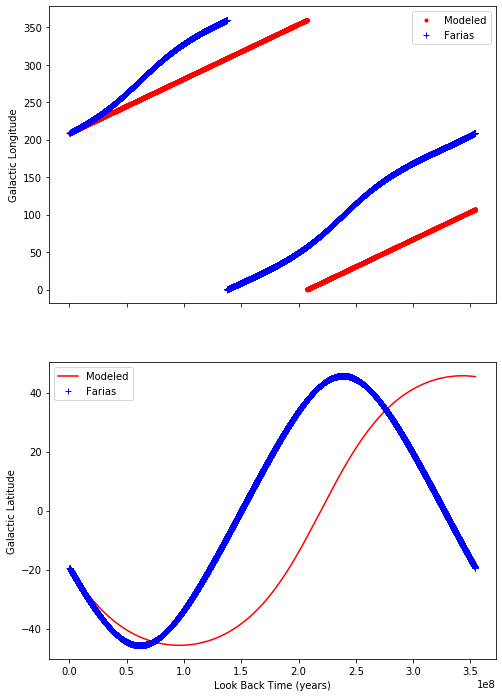

In [74]:
fig = plt.figure(figsize=(8,12))
ax = fig.subplots(2,1, sharex=True)
ax[0].plot(tsample_onc, l_t, '.', label='Modeled', color='red')
ax[0].plot(tsample_onc, lsample_onc, '+', label='Farias', color='blue')
ax[0].set_ylabel('Galactic Longitude')
ax[0].legend()

ax[1].plot(tsample_onc, b_t, label='Modeled', color='red')
ax[1].plot(tsample_onc, bsample_onc, '+', label='Farias', color='blue')
ax[1].legend()
ax[1].set_ylabel('Galactic Latitude')
ax[1].set_xlabel('Look Back Time (years)')

In [61]:
np.remainder(pmlc_onc* nyears, 360*units.degree).to(units.degree)

<Quantity 267.32420238 deg>

In [57]:
pmlc_onc* nyears, np.remainder(pmlc_onc* nyears, 360*units.degree)

(<Quantity -2780273.92872411 mas>, <Quantity 1.29321973e+09 mas>)

### Great Circle Distance same as `astropy.coordinates.separation`

In [23]:
ONC_prime = SkyCoord(l=l1, b=b1, frame='galactic')

In [24]:
ONC_prime

<SkyCoord (Galactic): (l, b) in deg
    (208.9794788, -19.35811971)>

In [25]:
ONC.separation(ONC_prime).to(units.radian)

<Angle 0.00077422 rad>

In [26]:
great_circle_distance(l1,b1, l0,b0)

<Quantity 0.00077422 rad>

In [27]:
np.allclose(ONC.separation(ONC_prime).to(units.radian), great_circle_distance(l1,b1, l0,b0))

True

`great_circle_distance` and `astropy.coordinates` appear to be equivalent.

## Coordinate Conversion

In [80]:
def to_spherical(cart):
    """
    cart: 3xn numpy array, {x, y, z}x n
    """
    distance = np.sqrt((cart**2).sum(axis=0)) * units.pc
    
    l = (np.arctan2(cart[1], cart[0])* units.radian).to(units.degree)
    l = np.where(l >= 0.0*units.degree, l, l+360*units.degree)
    b = (np.arctan(cart[2]/np.sqrt((cart[0]**2+cart[1]**2))) * units.radian).to(units.degree)
    
    return l, b, distance

def to_cart(l, b, d):
    x = d*np.cos(b)*np.cos(l)
    y = d*np.cos(b)*np.sin(l)
    z = d*np.sin(b)
    
    return np.array([x.value,y.value,z.value])
    
    

In [81]:
ONC.cartesian.xyz.value.reshape(3,1)

array([[-329.96324322],
       [-183.00937058],
       [-132.78489524]])

In [82]:
l,b,d = to_spherical(ONC.cartesian.xyz.value.reshape(3,1))
l,b,d

(<Quantity [209.01431152] deg>,
 <Quantity [-19.3879187] deg>,
 <Quantity [400.] pc>)

In [83]:
np.allclose(ONC.cartesian.xyz.value,to_cart(ONC.l, ONC.b, ONC.distance))

True

In [84]:
l,b,d =  to_spherical(ONC.cartesian.xyz.value)
np.allclose(np.array([ONC.l.value, ONC.b.value, ONC.distance.value]),
            np.array([l.value, b.value, d.value]))

True

Coordinate transformations appear to be working.

### Examine 3d Linear Motion over (long) time

In [136]:
t = np.linspace(-100e6,0,1001)*units.year
v_sun = np.array([11.1,12.24,7.25]).reshape(3,1) * units.km/units.s #Schronich+2010)
d_xyz = ONC.velocity.d_xyz.reshape(3,1) - v_sun
delta_xyz = (d_xyz*t.to(units.second)).to(units.pc)
xyz_t = ONC.cartesian.xyz.reshape(3,1)+delta_xyz

In [137]:
l,b,d = to_spherical(xyz_t.value)

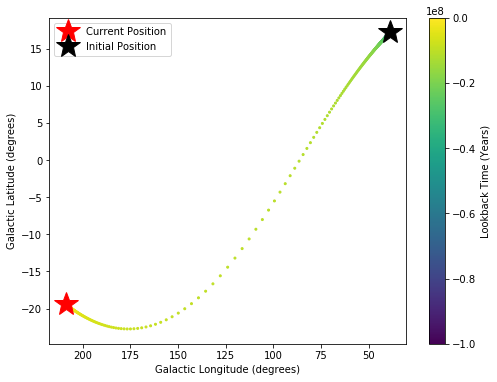

In [139]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
pcm=ax.scatter(l.to_value(units.degree), b.to_value(units.degree), c=t, s=4)
ax.plot(ONC.l, ONC.b,'*',markersize=25, color='red', label='Current Position')
ax.plot(l[0], b[0], '*', markersize=25, color='black', label='Initial Position')
ax.set_xlabel('Galactic Longitude (degrees)')
ax.set_ylabel('Galactic Latitude (degrees)')
ax.invert_xaxis()
ax.legend()
fig.colorbar(pcm, label='Lookback Time (Years)')

### Compare to Farias' Model

In [128]:
pmlc_onc, pmbc_onc = correct_gpm(ONC.l, ONC.b, ONC.pm_l_cosb, ONC.pm_b, distance = ONC.distance)
lsample_onc,bsample_onc,tsample_onc = great_circles_trajectory(ONC.l,ONC.b,pmlc_onc,pmbc_onc,N=10000,with_time=True,
                             limits=None,start_from_star=True)

t = -1*tsample_onc
v_sun = np.array([11.1,12.24,7.25]).reshape(3,1) * units.km/units.s #Schronich+2010)
d_xyz = ONC.velocity.d_xyz.reshape(3,1) - v_sun
delta_xyz = (d_xyz*t.to(units.second)).to(units.pc)
xyz_t = ONC.cartesian.xyz.reshape(3,1)+delta_xyz
l,b,d = to_spherical(xyz_t.value)

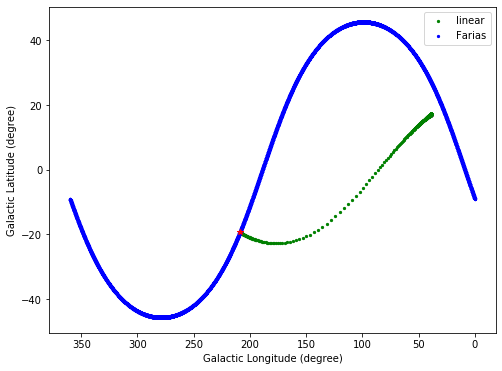

In [140]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
pcm=ax.scatter(l.to_value(units.degree), b.to_value(units.degree), s=5, color='green', label='linear')
ax.scatter(lsample_onc.to_value(units.degree), bsample_onc.to_value(units.degree), s=5, color='blue',label='Farias')
ax.plot(ONC.l, ONC.b,'*', color='red')

ax.set_xlabel('Galactic Longitude (degree)')
ax.set_ylabel('Galactic Latitude (degree)')
ax.invert_xaxis()
ax.legend()


Not so good!

### Compare linear projections

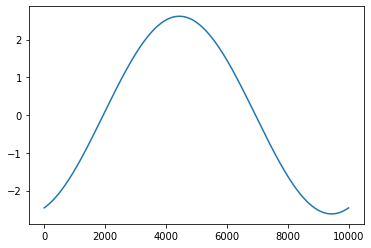

In [47]:
plt.plot(delta_b/delta_t)

In [17]:
gcd = great_circle_distance(lsample_onc[1], bsample_onc[1], lsample_onc[0], bsample_onc[0])
gcd.to(units.mas)/np.sqrt(pmlc_onc**2+pmbc_onc**2)

<Quantity 45102.67698104 yr>

In [ ]:
pmlc_onc*np.cos(ONC.b)

In [ ]:
lsample_onc-np.roll(lsample_onc,1)

In [ ]:
plt.plot((tsample_onc-np.roll(tsample_onc,1))[1:])

In [ ]:
plt.scatter(lsample_onc, (ONC.l+np.cumsum(pmlc_onc*tsample_onc)))

In [ ]:
plt.plot(tsample[0],great_circle_distance(lsample[0],bsample[0], lsample_onc, bsample_onc).value, color='blue')
plt.plot(tsample[1],great_circle_distance(lsample[1],bsample[1], lsample_onc, bsample_onc).value, color='red')

In [ ]:
i=1
max_tb_time = 4e6*units.year
mask = tsample[i] <= max_tb_time
min_i = great_circle_distance(lsample[i][mask],bsample[i][mask], lsample_onc[mask], bsample_onc[mask]).argmin()

In [ ]:
tsample[i,mask][min_i], tsample_onc[mask][min_i]

In [ ]:
np.sqrt((coords.velocity.d_xyz**2).sum(axis=0))

In [107]:
import sys, os
import numpy as np 

import matplotlib.pyplot as plt 



sys.path.append('..')
import astropy.units as u


print(f'Current Working Directory: {os.getcwd()}')

from locate_cluster_outliers.src.data_queries import querySIMBAD, formatSIMBADtoGAIA, getGAIAKnownMembers
from locate_cluster_outliers.src.gaiastars import gaiastars as gs

#construct a dict mapping cluster name in Table1a to its name in Simabad
name_mapper = {'Hyades': 'Hyades',
               'Coma Berenices Cluster':'ComaBer',
               'Pleiades':'Pleiades',
               'Praesepe': 'Praesepe',
               'alpha Per':'alphaPer',
               'IC 2391': 'IC2391',
               'IC 2602': 'IC2602',
               'Blanco 1': 'Blanco1',
               'NGC 2451A': 'NGC2451'}
cluster_info = querySIMBAD(name_mapper, formatGaia=True)

clusters = ['Pleiades', 'Hyades']

print(cluster_info.loc['Pleiades'])

print('\n------------ Gaia Known Members ------------')

cluster_members, cluster_names = getGAIAKnownMembers()
print(cluster_names)

cluster_known_members={}
for cl in cluster_names:
    cluster_known_members[cl]=gs(name=f'{cl} Known Members')
    km = list(cluster_members.query('Cluster==@cl').index)
    cluster_known_members[cl].from_source_idlist(km)


Current Working Directory: /home/kevin_leo_mcmanus/locate_cluster_outliers/WorksInProgress
Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


typed_id  parallax parallax_error    ra    ra_error   dec    dec_error    pmra     pmdec   radial_velocity rv_error cluster                          coords                       
            mas                   "h:m:s"           "d:m:s"             mas / yr  mas / yr      km / s      km / s                                 deg,deg,pc                     
-------- --------- -------------- -------- -------- -------- --------- --------- --------- --------------- -------- -------- -----------------------------------------------------
Pleiades     7.364              3 03 47 00        4 +24 07.0         4    19.997   -45.548           5.650    0.090 Pleiades 56.75009432548025,24.11647057028541,135.7958527032827

------------ Gaia Known Members ------------
['Hyades' 'ComaBer' 'Pleiades' 'Praesepe' 'alphaPer' 'IC2391' 'IC2602'
 'Blanco1' 'NGC2451']
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.c

In [108]:
center_pleiades = cluster_info.loc['Pleiades']['coords'].galactic

In [109]:
center_pleiades

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, pc)
    (166.57087621, -23.52125491, 135.7958527)
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    (45.44234694, -20.23578241, 5.65011969)>

In [110]:
center_pleiades.velocity

<CartesianDifferential (d_x, d_y, d_z) in km / s
    (-6.77617728, -28.4572492, -14.19906304)>

In [111]:
#pleiades_rv = gs(name='Pleiades with RV')
#pleiades_rv.objs = cluster_known_members['Pleiades'].objs[np.isfinite(cluster_known_members['Pleiades'].objs.radial_velocity)]
coords_pleiades = cluster_known_members['Pleiades'].get_coords().galactic

In [112]:
coords_pleiades[:5]

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, pc)
    [(171.38788037, -24.44264833, 136.91335626),
     (171.42459365, -24.42520918, 138.07822273),
     (170.42953229, -26.84745645, 130.29738698),
     (171.16744754, -25.35043405, 126.38870332),
     (171.45328993, -24.77604275, 139.21093974)]
 (pm_l_cosb, pm_b) in mas / yr
    [(46.17735638, -20.03502953), (44.61862651, -18.32401691),
     (47.55347728, -18.87689237), (48.26830255, -20.06523981),
     (45.03308554, -18.46039653)]>

In [114]:
from astropy.coordinates import GalacticLSR, Galactic, ICRS

In [115]:
pmlc_pleiades,pmbc_pleiades = correct_gpm(coords_pleiades.l
                                          ,coords_pleiades.b
                                          ,coords_pleiades.pm_l_cosb
                                          ,coords_pleiades.pm_b
                                          ,distance=coords_pleiades.distance)
coords_lsr = coords_pleiades.transform_to(GalacticLSR())
pml_glsr = coords_lsr.pm_l_cosb/np.cos(coords_lsr.b)
pmb_glsr = coords_lsr.pm_b

Text(0.5, 1.0, 'PM_B')

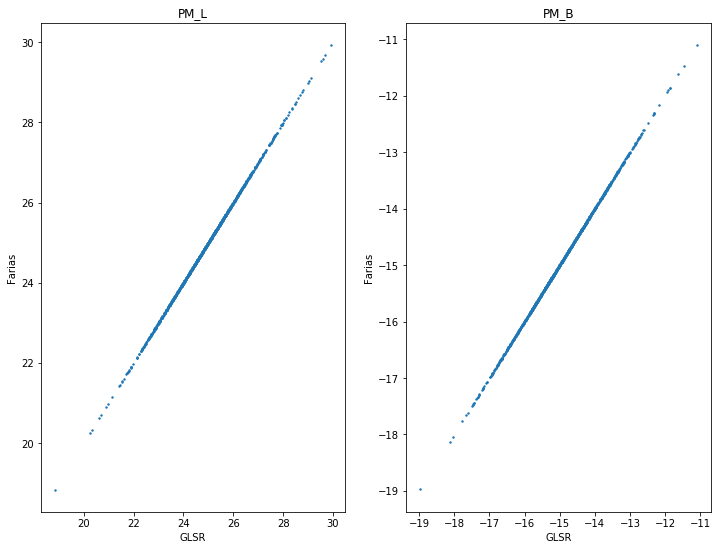

In [116]:
fig = plt.figure(figsize=(12,9))
ax = fig.subplots(1,2)
ax[0].scatter(pml_glsr.value, pmlc_pleiades.value, s=2)
ax[0].set_xlabel('GLSR')
ax[0].set_ylabel('Farias')
ax[0].set_title('PM_L')

ax[1].scatter(pmb_glsr.value, pmbc_pleiades.value, s=2)
ax[1].set_xlabel('GLSR')
ax[1].set_ylabel('Farias')
ax[1].set_title('PM_B')

In [118]:
print(f'PM_L All Close: {np.allclose(pml_glsr.value, pmlc_pleiades.value)}')
print(f'PM_B All Close: {np.allclose(pmb_glsr.value, pmbc_pleiades.value)}')

PM_L All Close: True
PM_B All Close: True


In [119]:
coords_lsr[:5]

<SkyCoord (GalacticLSR: v_bary=(11.1, 12.24, 7.25) km / s): (l, b, distance) in (deg, deg, pc)
    [(171.38788037, -24.44264833, 136.91335626),
     (171.42459365, -24.42520918, 138.07822273),
     (170.42953229, -26.84745645, 130.29738698),
     (171.16744754, -25.35043405, 126.38870332),
     (171.45328993, -24.77604275, 139.21093974)]
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(24.97020789, -15.69405287, -11.32255189),
     (23.59934117, -14.01996759, -11.3297224 ),
     (25.0250834 , -14.91941942, -11.22425883),
     (25.23665693, -15.62488465, -11.31785166),
     (24.19177524, -14.3009467 , -11.35301587)]>

In [120]:
coords_lsr.transform_to(ICRS())[:5]

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [(59.49378036, 20.40530388, 136.91335626),
     (59.53208837, 20.39380775, 138.07822273),
     (57.04311618, 19.3023086 , 130.29738698),
     (58.65844968, 19.90617499, 126.38870332),
     (59.28590962, 20.12842323, 139.21093974)]
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(18.24631583, -46.91292582,  0.00000000e+00),
     (18.34357188, -44.61059065,  2.15571639e-15),
     (21.05750643, -46.62887185, -4.31143277e-15),
     (20.01704474, -48.28830914, -2.15571639e-15),
     (18.59558001, -44.97743253,  6.46714916e-15)]>

In [121]:
cluster_known_members['Pleiades'].get_coords()[:5]

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [(59.49378036, 20.40530388, 136.91335626),
     (59.53208837, 20.39380775, 138.07822273),
     (57.04311618, 19.3023086 , 130.29738698),
     (58.65844968, 19.90617499, 126.38870332),
     (59.28590962, 20.12842323, 139.21093974)]
 (pm_ra_cosdec, pm_dec) in mas / yr
    [(18.24631583, -46.91292582), (18.34357188, -44.61059065),
     (21.05750643, -46.62887185), (20.01704474, -48.28830914),
     (18.59558001, -44.97743253)]>

/home/kevin_leo_mcmanus/anaconda3/envs/astro/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in arccos
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0, 0.5, 'Galactice Latitude')

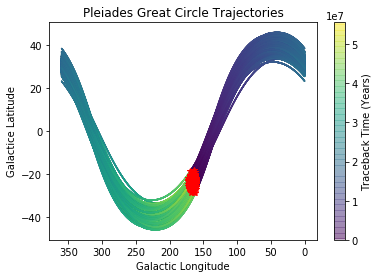

In [122]:
l_pleiades,b_pleiades = coords_pleiades.l,coords_pleiades.b 
#Corrected trajectory
pmlc_pleiades,pmbc_pleiades = correct_gpm(l_pleiades,b_pleiades,coords_pleiades.pm_l_cosb,coords_pleiades.pm_b,distance=coords_pleiades.distance)
lsample_pleiades,bsample_pleiades,tsample_pleiades = great_circles_trajectory(coords_pleiades.l,coords_pleiades.b,pmlc_pleiades,pmbc_pleiades
                            ,N=10000,with_time=True,
                             limits=None,start_from_star=True)
# Correct the ONC
pmlc_onc, pmbc_onc = correct_gpm(ONC.l, ONC.b, ONC.pm_l_cosb, ONC.pm_b, distance = ONC.distance)
lsample_onc,bsample_onc,tsample_onc = great_circles_trajectory(ONC.l,ONC.b,pmlc_onc,pmbc_onc,N=10000,with_time=True,
                             limits=None,start_from_star=True)


tback = 30.0*units.Myr


vmin = tsample_pleiades.min().value; vmax = tsample_pleiades.max().value
for l,b,t in zip(lsample_pleiades,bsample_pleiades,tsample_pleiades):
    #mask = t < tback
    #mask = np.array([True]*len(t))
    pcm = plt.scatter(l,b,   marker='.',s=1,alpha=0.3, c=t, vmin=vmin, vmax=vmax)
plt.plot(coords_pleiades.l,coords_pleiades.b,"*r")
plt.colorbar(pcm, label='Traceback Time (Years)')
plt.gca().invert_xaxis()
plt.title('Pleiades Great Circle Trajectories')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactice Latitude')

In [ ]:
import matplotlib
matplotlib.projections.get_projection_names()

In [ ]:
lsample[0].to_value(units.radian)

In [ ]:
from astropy.coordinates import Angle

In [ ]:
tmin = tsample_pleiades.min().value; tmax=tsample_pleiades.max().value
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(projection='mollweide')
pcm = ax.scatter(Angle(lsample_pleiades).wrap_at(180*units.degree).to_value(units.radian), bsample_pleiades.to_value(units.radian),
                 s=2, c=tsample_pleiades.value, vmin=tmin, vmax=tmax)
ax.plot(coords_pleiades.l.wrap_at(180*u.degree).radian,coords_pleiades.b.radian,"*r")
ax.grid()
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactice Latitude')
ax.set_title('Pleiades Member Great Circle Trajectories')
plt.colorbar(pcm, label='Traceback Time (Years)')

In [ ]:
zz=plt.hist(tsample_pleiades.max(axis=1).value, bins=50)

In [ ]:
print(f'Max traceback time: {int(tsample_pleiades.max().value):,} years')

In [ ]:
pleiades_rv.get_coords(recalc=True,default_rv=9)

In [ ]:
lsample_pleiades.min(), lsample_pleiades.max()

In [ ]:
np.roll(xx,1)

In [ ]:
import numpy as np

In [ ]:
#from https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu3ast/sec_cu3ast_intro/ssec_cu3ast_intro_tansforms.html#SSS1
A_G = np.array([[-0.0548755604162154, +0.4941094278755837, -0.8676661490190047],
                [-0.8734370902348850, -0.4448296299600112, -0.1980763734312015],
                [-0.4838350155487132, -0.7469822444972189, +0.4559837761750669] ])

In [ ]:
A_G.T